# Overview
This is just a simple first attempt at a model using InceptionV3 as a basis and attempting to do regression directly on the age variable using low-resolution images (224x224) in attempt to match the winning solution [here](https://www.16bit.ai/blog/ml-and-future-of-radiology) which scored an ```mae_months``` on the test set of 4.2

This can be massively improved with 
* high-resolution images
* better data sampling
* ensuring there is no leaking between training and validation sets, ```sample(replace = True)``` is real dangerous
* better target variable (age) normalization
* pretrained models
* attention/related techniques to focus on areas

In [1]:
# copy the weights and configurations for the pre-trained models

In [2]:
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [4]:
base_bone_dir = os.path.join('..', 'input', 'rsna-bone-age')
age_df = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
age_df['path'] = age_df['id'].map(lambda x: os.path.join(base_bone_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
# we don't want normalization for now
boneage_mean = 0
boneage_div = 1.0
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
11119,13953,162,True,../input/rsna-bone-age/boneage-training-datase...,True,male,162.0
8556,11072,156,True,../input/rsna-bone-age/boneage-training-datase...,True,male,156.0
422,1851,57,True,../input/rsna-bone-age/boneage-training-datase...,True,male,57.0


# Examine the distribution of age and gender
Age is shown in months

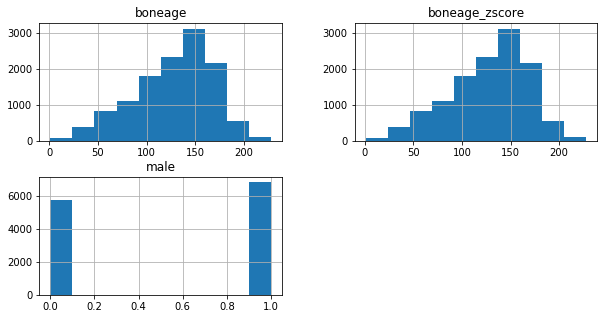

In [5]:
age_df[['boneage', 'male', 'boneage_zscore']].hist(figsize = (10, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)

# Split Data into Training and Validation

In [6]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = age_df['boneage_category'])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 9458 validation 3153


# Balance the distribution in the training set

New Data Size: 10000 Old Size: 9458


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4664dab7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4664b74240>]], dtype=object)

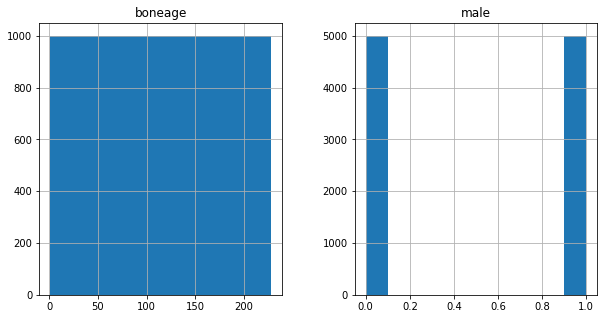

In [7]:
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['boneage', 'male']].hist(figsize = (10, 5))

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (224, 224) # default size for inception_v3
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'reflect',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)

Using TensorFlow backend.


In [9]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [10]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 8)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images


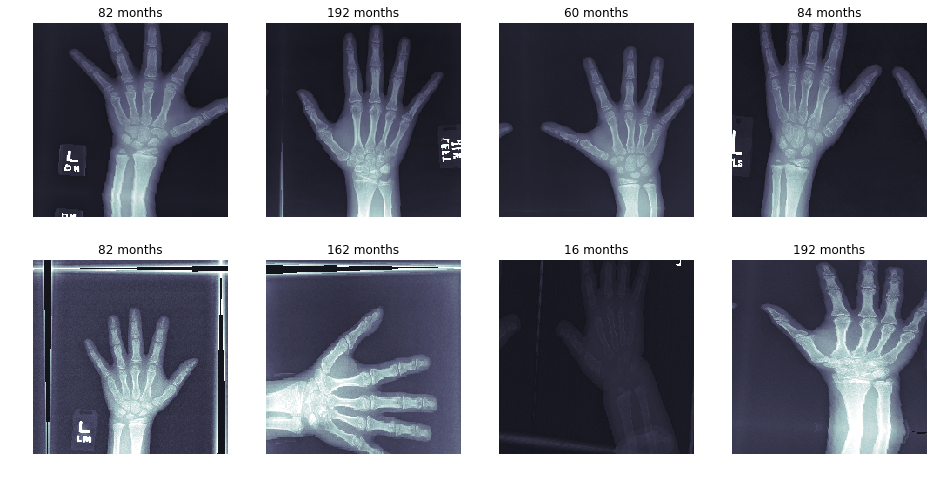

In [11]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features


In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_iv3_model = InceptionV3(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_iv3_model.trainable = False
bone_age_model = Sequential()
bone_age_model.add(base_iv3_model)
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1024, activation = 'tanh'))
bone_age_model.add(Dropout(0.25))
bone_age_model.add(Dense(1, activation = 'linear')) # linear is what 16bit did
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
________________________________________________________

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [14]:
bone_age_model.fit_generator(train_gen, 
                                  steps_per_epoch=300,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 4, 
                                  callbacks = callbacks_list)

Epoch 1/4
299/300 [============================>.] - ETA: 1s - loss: 4848.8823 - mae_months: 58.9758
Epoch 00001: val_loss improved from inf to 1856.67736, saving model to bone_age_weights.best.hdf5
300/300 [==============================] - 629s 2s/step - loss: 4846.0241 - mae_months: 58.9504 - val_loss: 1856.6774 - val_mae_months: 36.5878
Epoch 2/4
299/300 [============================>.] - ETA: 1s - loss: 3959.5606 - mae_months: 54.5339
Epoch 00002: val_loss improved from 1856.67736 to 1651.06493, saving model to bone_age_weights.best.hdf5
300/300 [==============================] - 614s 2s/step - loss: 3956.4625 - mae_months: 54.4996 - val_loss: 1651.0649 - val_mae_months: 33.3210
Epoch 3/4
299/300 [============================>.] - ETA: 1s - loss: 3055.9087 - mae_months: 47.2658
Epoch 00003: val_loss did not improve
300/300 [==============================] - 648s 2s/step - loss: 3050.5074 - mae_months: 47.1940 - val_loss: 2023.7560 - val_mae_months: 34.0896
Epoch 4/4
299/300 [=====

# Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec

In [15]:
bone_age_model.load_weights(weight_path)

In [16]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 32, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

1024/1024 [==============================] - 159s 155ms/step


Text(0,0.5,'Predicted Age (Months)')

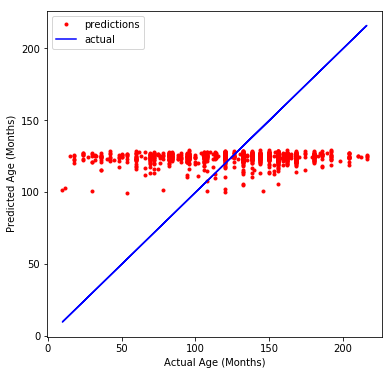

In [17]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [18]:
ord_idx = np.argsort(test_Y)
ord_idx = ord_idx[np.linspace(0, range(len(ord_idx)), 8).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1f\nPredicted Age: %2.1f' % (test_Y_months[idx], pred_Y[idx]))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()